# Comparative Analysis of Canny, Laplacian and Roberts Edge Detection Algorithm

In [ ]:
# Importing Necessary Packages

from matplotlib.image import imread
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

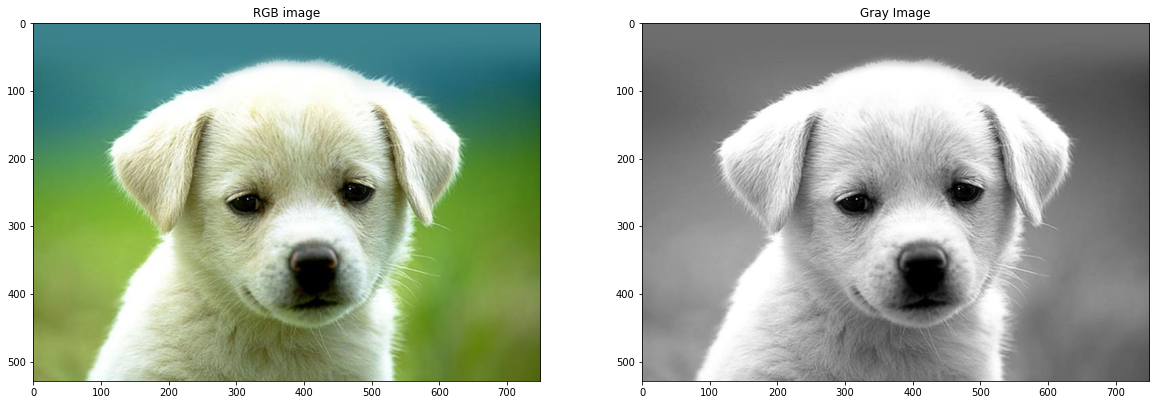

In [ ]:
# Grayscaling Image using method of luminance
# Test image source at the time of writing code is https://wallpapercave.com/wp/ly2XKAs.jpg


my_image = imread("/content/drive/MyDrive/Python/dog_image.jpg")                    ## Image Path for any image to test
R, G, B = my_image[:,:,0],my_image[:,:,1],my_image[:,:,2]
p = 1
w1, w2, w3 = 0.2990, 0.5870 , 0.1140
my_image_grayscale = w1*R**p + w2*G**p + w3*B**p
fig = plt.figure(figsize=(20,20))
fig.add_subplot(121)
plt.imshow(my_image)
plt.title("RGB image")
fig.add_subplot(122)
plt.imshow(my_image_grayscale, cmap = plt.cm.get_cmap('gray'))
plt.title("Gray Image")
plt.show()
test = cv2.resize(my_image_grayscale, (256, 256))



**Edge Detection with Canny Edge Detection Algorithm :**



Flow:

GrayScale Image --------->Gaussian Blur -------> Intensity Gradient Calculator(sobel Operator)------>Non-Maximum suppression------>Thresholding------>Final Cleansing(Hysteresis)



In [ ]:
# 2D convolution

def my_convolution(any_image, gauss_kernel):

    print(" \033[1m  Conv. Output Features :  \033[0m \n")
    kernel = np.flipud(np.fliplr(gauss_kernel))                                                                                     #180 degree flipped gauss kernel
    gauss_kernel_row, gauss_kernel_col = kernel.shape
    print( " kernel size : " , gauss_kernel.shape)

    img_row, img_col = any_image.shape
    print( " image size :", any_image.shape)

    output_conv = np.zeros(any_image.shape)
    # print( "intial output :", output_conv)

    pad_height = int((gauss_kernel_row - 1) / 2)
    print( " pad height :", pad_height)

    pad_width = int((gauss_kernel_col - 1) / 2)
    print( " pad width :", pad_width)
    
    image_padd = np.zeros((img_row + (2 * pad_height), img_col + (2 * pad_width)))                                                 #padded image intiialization
    image_padd[pad_height:image_padd.shape[0] - pad_height, pad_width:image_padd.shape[1] - pad_width] = any_image                 # inner portion of padded image replaced by original/input image
                                                                                                                                         
    for i in range(img_row):
        for j in range(img_col):
            output_conv[i, j] = np.sum(kernel * image_padd[i:i + gauss_kernel_row, j:j + gauss_kernel_col])                  # Convolution Operation(multiplications and sum)

    return output_conv

In [ ]:
# Gaussian Blurr kernel

def gaussian_func(sig, kernel_size):
  a = kernel_size[ 0 ]
  b = kernel_size[ 1 ]
  x,y = np.arange((-(a-1)/2),a/2) , np.arange((-(b-1)/2),b/2)
  X,Y = np.meshgrid(x,y)
  gauss =  (np.exp(-(X ** 2 + Y ** 2 )/(2 * sig ** 2)))/ ( 2 * math.pi * sig ** 2 )
  fig = plt.figure(figsize=(5,5))
  fig.add_subplot()
  plt.imshow(gauss, cmap = 'gray')
  plt.title("Gaussian Kernel")
  return gauss/gauss.sum()
  
def gaussian_blur(image):
    kernel = gaussian_func(2.00, (25,25))                        
    return my_convolution(image, kernel)



In [ ]:
# Intensity Gradient Calculator(Sobel Filter)

def sobel_filter(sobel_input_image):

  G_x = np.array([[1,0,-1],[2,0,-2],[+1,0,-1]], np.float32)
  G_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]], np.float32)

  I_x = convolve(sobel_input_image, G_x)
  I_y = convolve(sobel_input_image, G_y)

  G = np.hypot(I_x, I_y)
  G = G/G.max() * 255
  angle = np.arctan2(I_y, I_x)

  return (G , angle)

In [ ]:
# NON-MAX SUPPRESSION : NMS

def nms(gradient_magnitude, gradient_angle):
 
    nms_output = np.zeros(gradient_magnitude.shape)
    img_row, img_col = gradient_magnitude.shape

    for row in range(1, img_row - 1):
      for col in range(1, img_col - 1):
        angle = gradient_angle[row, col]

        if(0 <= angle < 22.5) or (337.5 <= angle <= 360):
            prev_pixel = gradient_magnitude[row, col - 1]
            later_pixel = gradient_magnitude[row, col + 1]
            
 
        elif (22.5 <= angle < 67.5) or (202.5 <= angle < 247.5):
            prev_pixel = gradient_magnitude[row + 1, col - 1]
            later_pixel = gradient_magnitude[row - 1, col + 1]
 
        elif (67.5 <= angle < 112.5) or (247.5 <= angle < 292.5):
           prev_pixel = gradient_magnitude[row - 1, col]
           later_pixel = gradient_magnitude[row + 1, col]
 
        else:
           prev_pixel = gradient_magnitude[row - 1, col - 1]
           later_pixel = gradient_magnitude[row + 1, col + 1]
 
        if gradient_magnitude[row, col] >= prev_pixel and gradient_magnitude[row, col] >= later_pixel:
            nms_output[row, col] = gradient_magnitude[row, col]

    return nms_output



In [ ]:
# Thresholding + Hysteresis Integrated

def thresholding(input_image, low_value, high_value, weak_value ):

    thresh_output = np.zeros(input_image.shape)
    img_row, img_col = input_image.shape
    strong_value = 255

    for i in range ( 1 , img_row - 1):
      for j in range (1 , img_col - 1):
        
        if input_image[i,j] >= high_value :
          thresh_output[i,j] = strong_value

        elif low_value <= input_image[i,j] and input_image[i,j]<= high_value :
          thresh_output[i,j] = weak_value
          if (thresh_output[i,j] <= weak_value):                                                                            #Hysteresis part ,  apply on weak pixels
            if ((thresh_output[i+1, j-1] == 255) or (thresh_output[i+1, j] == 255) or (thresh_output[i+1, j+1] == 255 )
                or (thresh_output[i, j-1] == 255) or (thresh_output[i, j+1] == 255)
                or (thresh_output[i-1, j-1] == 255 ) or (thresh_output[i-1, j] == 255) or (thresh_output[i-1, j+1] == 255)):
              thresh_output[i,j] = 255
            else :
              thresh_output[i,j] = 0
                  
        else :
          thresh_output[i,j] = 0

    return thresh_output
 

   Conv. Output Features :   

 kernel size :  (25, 25)
 image size : (529, 750)
 pad height : 12
 pad width : 12
Shape Of output Image :  (529, 750)


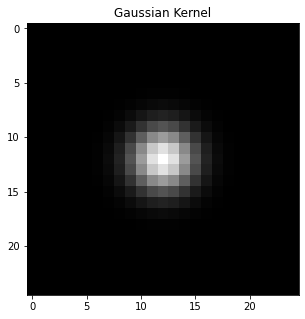

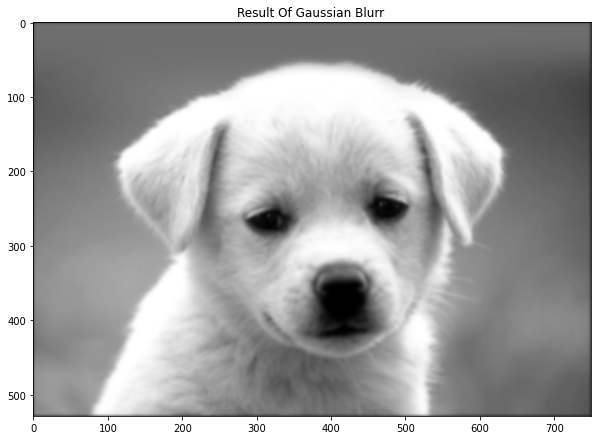

In [ ]:
#Testing the Gaussian Blurr

conv_image = gaussian_blur(my_image_grayscale)
print("Shape Of output Image : " , conv_image.shape )
fig = plt.figure(figsize=(10,10))
plt.imshow(conv_image, cmap = 'gray')
plt.title("Result Of Gaussian Blurr ")
plt.show()

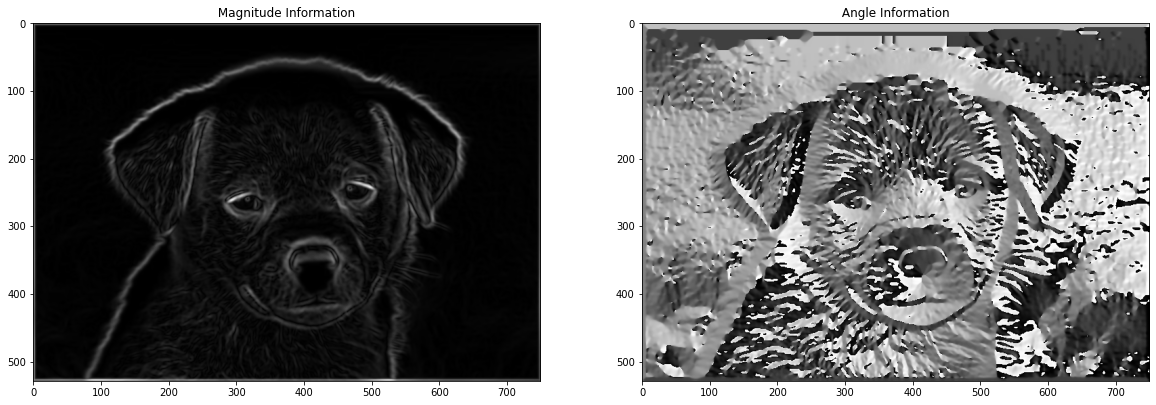

In [ ]:
# Results of applying Sobel filter 

sobel_filtered_image = sobel_filter( conv_image)
gradient_magnitude = sobel_filtered_image[0]
gradient_angle = sobel_filtered_image[1]
fig = plt.figure(figsize = (20,20))
fig.add_subplot(121)
plt.imshow(gradient_magnitude , cmap = plt.cm.get_cmap('gray'))
plt.title(" Magnitude Information " )
fig.add_subplot(122)
plt.imshow(gradient_angle , cmap = plt.cm.get_cmap('gray' ))
plt.title(" Angle Information ")
plt.show()

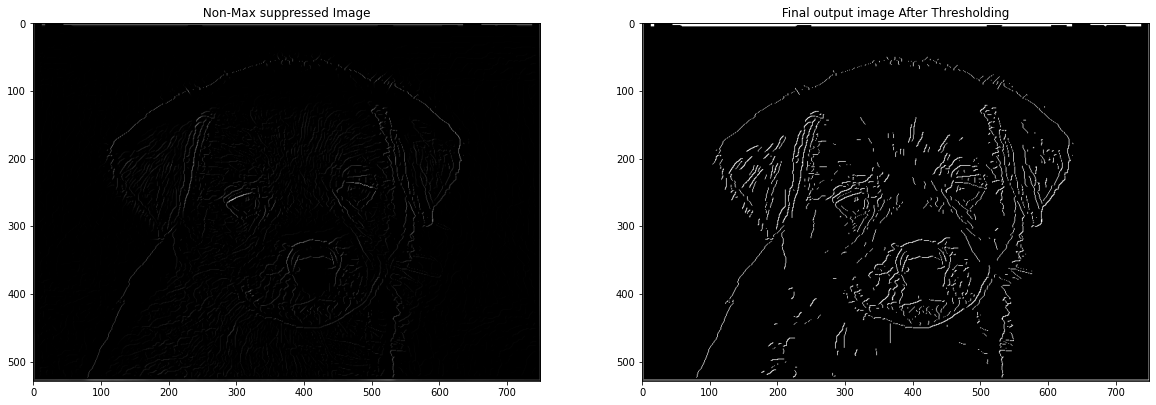

In [ ]:
#  NON-MAX Supression and  Thresholding

supressed_image = nms(gradient_magnitude, gradient_angle)
canny_output_image = thresholding(supressed_image, 10 , 30 , 20)                     #low , high, weak values
fig = plt.figure(figsize = (20,20))
fig.add_subplot(121)
plt.imshow(supressed_image,cmap= 'gray')
plt.title(" Non-Max suppressed Image " )
fig.add_subplot(122)
plt.imshow(canny_output_image, cmap = 'gray')
plt.title( " Final output image After Thresholding ")
plt.show()



**Laplacian Edge Detection :**

 Flow:

GrayScale_Image----->Apply LoG ------>Find zero crossings ---> Zero crossing pixels are edges

In [ ]:
# 1. LoG of Gaussian ---> Similar to gaussian but we use LoG(x,y) function instead of gaussian function 

def LoG(sig, kernel_size):
  
  a = kernel_size[ 0 ]
  b = kernel_size[ 1 ]
  x,y = np.arange((-(a-1)/2),a/2) , np.arange((-(b-1)/2),b/2)
  X,Y = np.meshgrid(x,y)
  alpha = -1/(math.pi * ( sig ** 4 ))
  beta = (1 - (X ** 2 + Y ** 2 )/(2 * sig ** 2))
  gamma =  (np.exp(-(X ** 2 + Y ** 2 )/(2 * sig ** 2)))
  LoG = alpha  * beta * gamma
  fig = plt.figure(figsize=(5,5))
  fig.add_subplot()
  plt.imshow(LoG, cmap = 'gray')
  plt.title("LoG Kernel")
  return LoG/LoG.sum()
  
def LoG_operation(image):
    kernel = LoG(2.00, (15,15))                       
    return my_convolution(image, kernel)

In [ ]:
# Zero Crossings (8 neighbors - 2 horizontal, 2 vertical , 2 on each diagonals)

def zero_crossing(image):
  zero_cross_output = np.zeros(image.shape)
  img_row = image.shape[0]
  img_col = image.shape[1]

  for i in range(1 , img_row - 1):
    for j in range(1 , img_col - 1 ):
      if image[i,j] > 0 :
        if image[i-1 , j-1] < 0 or image[i-1 , j] < 0 or image[i-1 , j+1] < 0 or image[i , j-1] < 0 or image[i , j+1] < 0 or image[i+1 , j-1] < 0 or image[i+1 , j] < 0  or image[i+1 , j+1] < 0:
          zero_cross_output[ i , j ] = 1

      elif  image[ i ,j ] < 0 :
        if image[i-1 , j-1] > 0 or image[i-1 , j] > 0 or image[i-1 , j+1] > 0 or image[i , j-1] > 0 or image[i , j+1] > 0 or image[i+1 , j-1] > 0 or image[i+1 , j] > 0  or image[i+1 , j+1] > 0:
          zero_cross_output[ i , j ] = 1

      else: zero_cross_output[i,j] = 0

  return zero_cross_output

   Conv. Output Features :   

 kernel size :  (15, 15)
 image size : (529, 750)
 pad height : 7
 pad width : 7


Text(0.5, 1.0, ' Final Image After Zero-Crossing ')

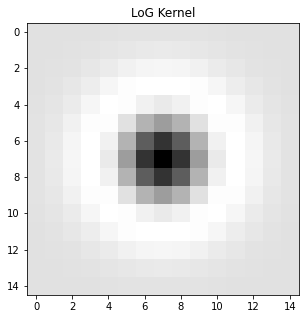

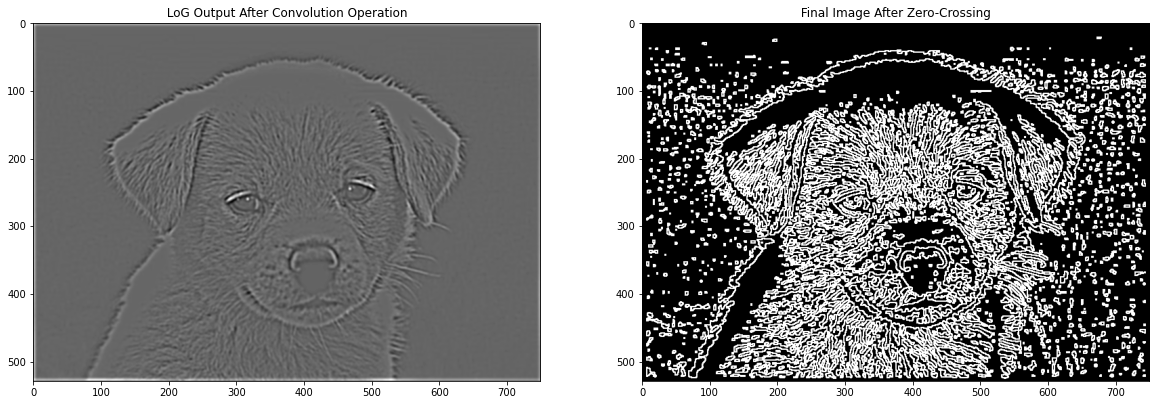

In [ ]:
# Testing LoG output, Zero-Crossing output and Final Output

LoG_output = LoG_operation(my_image_grayscale)
z_c_out = zero_crossing(LoG_output)
fig = plt.figure(figsize=(20,20))
fig.add_subplot(121)
plt.imshow(LoG_output , cmap = 'gray')
plt.title(" LoG Output After Convolution Operation ")
fig.add_subplot(122)
plt.imshow(z_c_out , cmap = 'gray')
plt.title( " Final Image After Zero-Crossing ")

**Robert Edge Detection Algorithm:**

Flow : Grayscale Image -------> Initialize roberts cross ----> calculate horizontal and vertical gradient -----> calculate G , magnitude of both vertical and horizontal gradient--->Thresholding  ....(similar to sobel operation, only difference is using roberts mask/cross )


In [ ]:
# Robert Function

def roberts_func(input_image):
  output_image = np.zeros(input_image.shape)
  img_row , img_col = input_image.shape

  roberts_horizontal_cross = np.array( [ [0 , 0 , 0 ] , [ 0 , 0 , 1 ] , [ 0 , 0 , -1 ] ] )
  roberts_vertical_cross = np.array( [ [ 0 , 0 , 0 ] , [ 0 , 0 , 1 ] , [ 0 , -1 , 0 ] ] )

  G_x = convolve(input_image , roberts_horizontal_cross )
  G_y = convolve( input_image , roberts_vertical_cross )

  output_image = np.sqrt( ( G_x ) ** 2 + ( G_y ) ** 2 )

  return output_image 

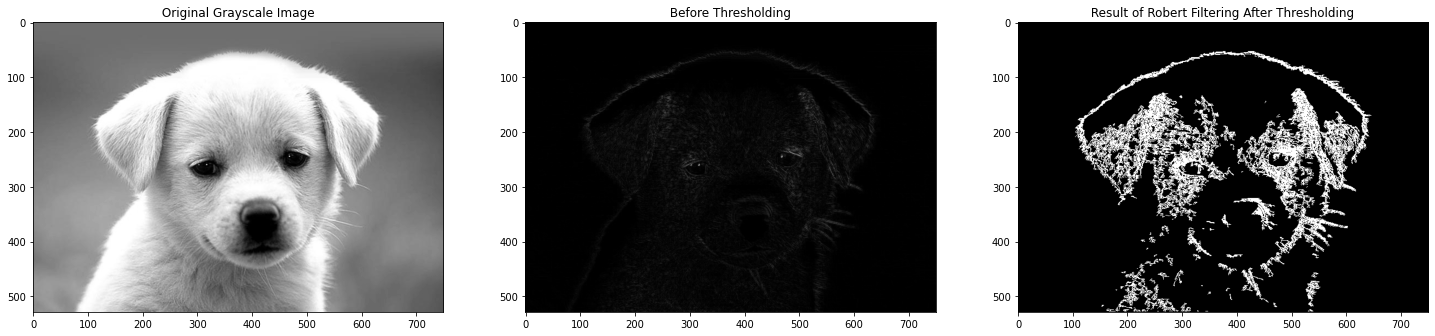

In [ ]:
# Testing Robert Edge Detection Algorithm

robert_filtered_image = roberts_func(my_image_grayscale)
roberts_output_final  = thresholding( robert_filtered_image , 10 , 30 , 20 )
fig = plt.figure(figsize = (25,25))
fig.add_subplot(131)
plt.imshow(my_image_grayscale , cmap ='gray')
plt.title(" Original Grayscale Image ")
fig.add_subplot(132)
plt.imshow(robert_filtered_image , cmap ='gray')
plt.title(" Before Thresholding ")
fig.add_subplot(133)
plt.imshow(roberts_output_final , cmap = 'gray')
plt.title(" Result of Robert Filtering After Thresholding ")
plt.show()

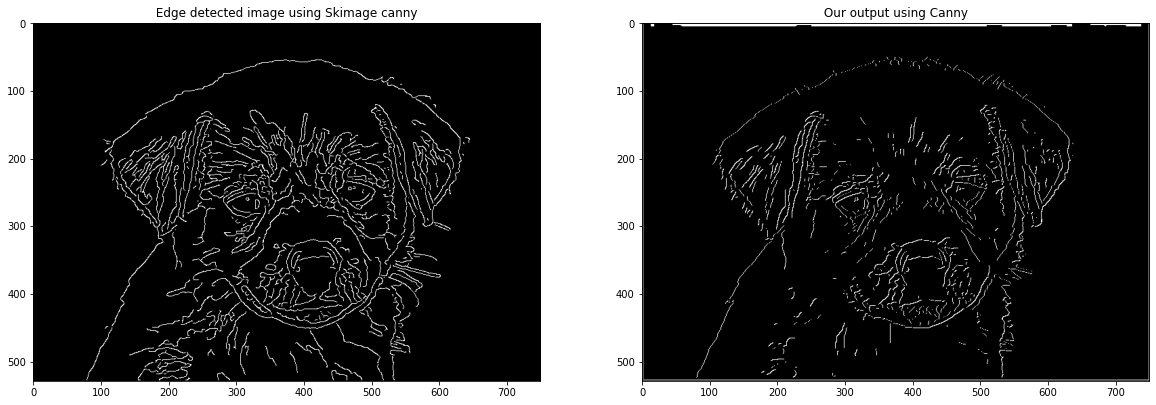

In [ ]:
# Result Comparison 

# 1. Using Standard skimage and scipy package result as standard for Image comparison

# A. Canny

from skimage import feature

standard_image1 = feature.canny(my_image_grayscale , sigma = 2, low_threshold= 10, high_threshold= 30 )
fig =plt.figure(figsize=(20,20))
fig.add_subplot(121)
plt.imshow(standard_image1 , cmap= 'gray')
plt.title(" Edge detected image using Skimage canny " )
fig.add_subplot(122)
plt.imshow(canny_output_image, cmap = 'gray')
plt.title( " Our output using Canny ")
plt.show()

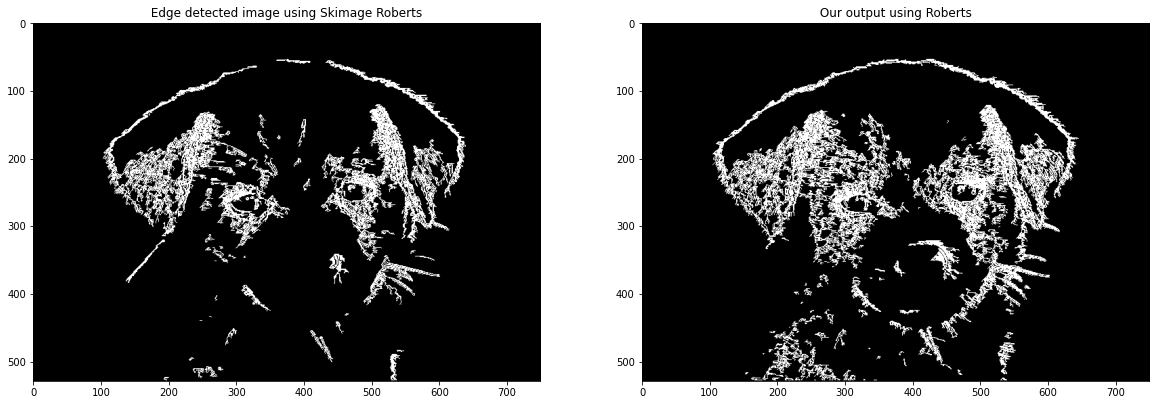

In [ ]:
# B. Roberts 

from skimage import filters 

standard_image2 = thresholding(filters.roberts(my_image_grayscale) , 10 , 30 , 20) 
fig =plt.figure(figsize=(20,20))
fig.add_subplot(121)
plt.imshow(standard_image2 , cmap ='gray')
plt.title(" Edge detected image using Skimage Roberts " )
fig.add_subplot(122)
plt.imshow(roberts_output_final, cmap = 'gray')
plt.title( " Our output using Roberts ")
plt.show()

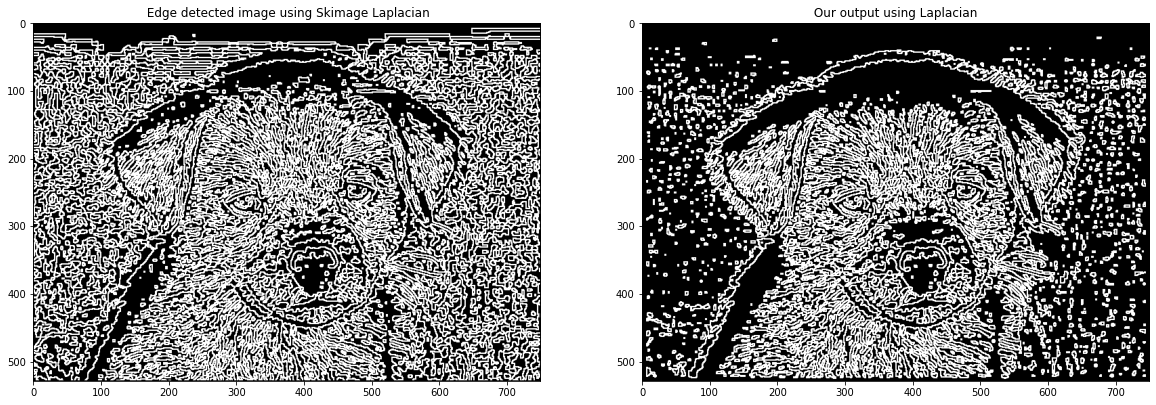

In [ ]:
# C. LoG

from scipy.ndimage import gaussian_laplace

standard_image3 = zero_crossing(gaussian_laplace(my_image_grayscale ,2 ))
fig =plt.figure(figsize=(20,20))
fig.add_subplot(121)
plt.imshow(standard_image3 , cmap ='gray')
plt.title(" Edge detected image using Skimage Laplacian" )
fig.add_subplot(122)
plt.imshow(z_c_out, cmap = 'gray')
plt.title( " Our output using Laplacian ")
plt.show()

In [ ]:
# 2. Cosine Similarity

from numpy import dot
from numpy.linalg import norm

def cos_sim(input_image , standard_image):
  return dot(input_image , standard_image)/ (norm(input_image) * norm(standard_image))

CosSim_canny = cos_sim( np.concatenate(canny_output_image) , np.concatenate(standard_image1))        
CosSim_LoG = cos_sim( np.concatenate(z_c_out) , np.concatenate(standard_image1) )
CosSim_roberts = cos_sim( np.concatenate(roberts_output_final) , np.concatenate(standard_image1) )
print(" \033[1m CosSim Canny: {} \n  CosSim LoG: {} \n  CosSim Roberts: {}  \033[0m".format(  round(CosSim_canny , 2) , round(CosSim_LoG, 2) , round(CosSim_roberts, 2)))

  CosSim Canny: 0.39 
  CosSim LoG: 0.32 
  CosSim Roberts: 0.26  


In [ ]:
## 3. Using Peak Signal to noise ratio for  the three Algorithms (How much of total signal is recovered) 

from math import log10, sqrt

def PSNR(original_image, algorithm_output_image):
    max_pixel_value = 255.0
    mse = np.mean((original_image - algorithm_output_image) ** 2)
    if(mse == 0): 
        return 100
    psnr = 20 * log10(max_pixel_value / sqrt(mse))
    return psnr

psnr_canny = PSNR(my_image_grayscale , canny_output_image)
psnr_LoG = PSNR (my_image_grayscale , z_c_out)
psnr_roberts = PSNR(my_image_grayscale , roberts_output_final)

print(" \033[1m PSNR Canny(dB): {} \n  PSNR LoG(dB): {} \n  PSNR Roberts(dB): {} \033[0m".format(  round(psnr_canny , 2) , round(psnr_LoG, 2) , round(psnr_roberts, 2)))

  PSNR Canny(dB): 4.05 
  PSNR LoG(dB): 4.01 
  PSNR Roberts(dB): 4.43 
